# 1 Importing libraries and loading data

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import time

np.seterr(divide='ignore', invalid='ignore')

# useful function to load CIFAR-10 datasets
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def show_performance(true_values, predicted_values, posteriors):
    print("The accuracy is: %.2f%%" % ((true_values == predicted_values).sum() / len(true_values) * 100))
    print("The log-likelihood is: %.2f" % log_loss(true_values, posteriors))

In [2]:
# loading datasets

# fashion MNIST
fashion_mnist_train = pd.read_csv("./datasets/fashion-mnist_train.csv") 
fashion_mnist_test = pd.read_csv("./datasets/fashion-mnist_test.csv")

# CIFAR-10 train (flatten)
baseName = "./datasets/cifar-10-batches-py/data_batch_"
X_train = np.array([row for batch in [unpickle(baseName + str(i))[b'data'] for i in range(1, 6)] for row in batch])
y_train = np.array([label for batch in [unpickle(baseName + str(i))[b'labels'] for i in range(1, 6)] for label in batch])
cifar10_train = pd.DataFrame(X_train)
cifar10_train["class"] = y_train

# CIFAR-10 test (flatten)
X_test = unpickle("./datasets/cifar-10-batches-py/test_batch")[b'data']
y_test = unpickle("./datasets/cifar-10-batches-py/test_batch")[b'labels']
cifar10_test = pd.DataFrame(X_test)
cifar10_test["class"] = y_test

# 2 Data analysis

# 2.1 Fashion MNIST analysis

In [3]:
fashion_mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("Fashion MNIST - number of rows:", len(fashion_mnist_train))

Fashion MNIST - number of rows: 60000


<div class="alert alert-success">
<b>Fashion MNIST - General overview</b><br>
From the previous results we can see that we have a training set with 60000 rows: a large amount of data in order to (potentially) have a good training. The dimensionality is high: 785 features (28x28 resolution + 1 target). This is a problem for many models but in this case we are going to use Naïve Bayes that is really good at dealing with this fact (in the next section we'll discover why). 
</div>

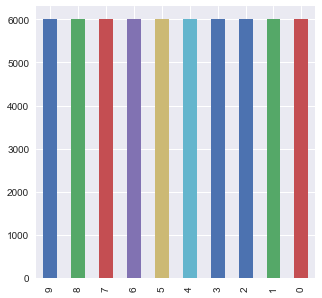

In [5]:
plt.figure(figsize=(5,5))
pd.value_counts(fashion_mnist_train['label']).plot.bar()

<div class="alert alert-success">
<b>Fashion MNIST - About the class distribution</b><br>
It is really important taking a look at class distribution because based on this analysis we should take a decision on our prior (see next section for better explanation on Naïve Bayes). In this case we can see that we have the same number of instaces for each class so we can conclude that there is no prior preference; in other words we can assume that the prior distribution is uniform: each class has P(t_new = Class) = 1 / K, where K is the number of classes.
</div>

# 2.2 CIFAR-10 analysis

In [6]:
cifar10_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,class
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [7]:
print("CIFAR-10 - number of rows:", len(cifar10_train))

CIFAR-10 - number of rows: 50000


<div class="alert alert-success">
<b>CIFAR-10 - General overview</b><br>
From the previous results we can see that we have a training set with 50000 rows. The dimensionality is really high, more than before: 3073 features; that's because in this case we have 32x32 RGB images (32x32x3 + 1 target feature). Again, with Naïve Bayes is perfect in this case (under the point of view of computational cost) but of course we don't know if all the attributes are independent (intuitively not). We'll see looking at performance metrics. 
</div>

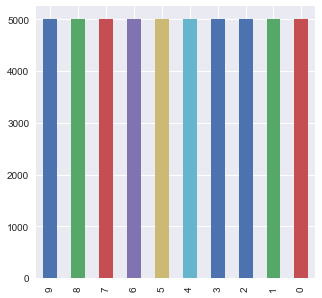

In [8]:
plt.figure(figsize=(5,5))
pd.value_counts(cifar10_train['class']).plot.bar()

<div class="alert alert-success">
<b>CIFAR-10 - About the class distribution</b><br>
Even in this case we have the same number of instaces for each class. Therefore the prior distribution is again uniform: each class has P(t_new = Class) = 1 / K, where K is the number of classes.
</div>

# 2.3 Pre-processing suggestions

<div class="alert alert-success">
When we talk about data pre-processing we immediately think about outliers, feature engineering and dimensionality reduction.<br><br>

About the first one in this case we can't say too much in this notebook: for sure there is a lot of research out there about outlier-removal in image-classification but it is about image processing, therefore out of scope of this assignment.<br><br>

About feature engineering a easy-to-do operation is scaling, which speed-up our algorithms. All the values we are dealing are between 0 and 255 (grayscale images for MNIST or single R/G/B channel for CIFAR10), so we can simply use a scale from 0 to 1. An alternative to this approach could be converting all the images in Black/White in order to have only 0 or 1 as values, simplyfing the features, but probably we would lose too much information. A reasonable transformation, in the case of CIFAR10, is converting the RGM images to grayscale: it means reducing drastically the number of features (from 3072 to 1024).<br><br>

Dimensionality reduction could be a good thing, we have really high dimensional data. The first technique we may think is PCA (Principal Component Analysis). At first glance it seems a good idea because we will obtain uncorrelated features and it is the best case for Naïve Bayes. It's actually problematic: it does NOT CARE AT ALL about labels. It simply finds the directions where most of the variance is explained, but it could make our classification problem much more difficult. For example the class instances could be linearly separable but they are distributed in a certain way that after PCA they are not. We should use LDA (Linear Discriminant Analysis) but in this case we are talking about another model, i.e. supervised learning.
</div>

<img style="width:400px; height:200px" src="http://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png">

# 3 Classification

## 3.1 Naïve Bayes implementation

<div class="alert alert-success">
<b>Naïve Bayes: the goal</b><br>
In this classification model we would compute, given the input x, the probability that it belongs to class C_k. But in many cases this task is unfeasible, for this reason we use the Bayes theorem to solve the problem from another point of view.
</div>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/52bd0ca5938da89d7f9bf388dc7edcbd546c118e">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0122d84d632cc399d2a49924797f37a7db53b0c">

<div class="alert alert-success">
<b>Naïve Bayes: how to proceed</b><br>
As showed in the last pictures, we should define a prior and compute the likelihood in order to get what we are looking for. From the previous analysis we have decided that the prior is a uniform distribution, where each class has probability 1/K. In the case of likelihood we suppose that attributes have normal distribution, so we can easily compute the likelihood for each attribute with this formula:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/685339e22f57b18d804f2e0a9c507421da59e2ab">
</div>

<div class="alert alert-success">
<b>Naïve Bayes: pros and cons</b><br>
This model is really easy to implement and computationally fast, especially when we are dealing with large amout of data with high dimensionality (like in our case). The other side of the coin is the model makes a strong assumption: <u>independence among features</u>; for this reason it is called "naïve". This assumption brings all the advantages which I talked about before but at the same time we should care if it is (quite) true in our data. If it is not, probably we'll have poor results.<br><br>

Making this assumption our life is easy: in order to compute p(x | C_k) we can simply compute the likelihood for each attribute and multiply them to obtain the likelihood for a specific class. At the end we simply choose the most likely:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/5ed52009429e5f3028302427a067822fdfc58059">
</div>

In [43]:
class NaiveBayes:
    def __init__(self, priors=None):
        self.noise = 10e-5
        self.priors = priors
    
    
    def fit(self, X, y):
        
        # separate rows by target class
        
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        
        # for all the rows belonging to the same class compute the mean and std dev for each attribute
        # obtaining two matrices nb of classes x nb of features
        # adding some noise in stds to avoid instability (division by zero problem)
        
        self.means = np.array([np.mean(g, axis=0) for g in separated])
        self.stds = np.array([np.std(g, axis=0) for g in separated]) + self.noise
        
        # check if the prior is set otherwise assume uniform
        
        if self.priors is not None:
            if len(self.priors) != len(self.means):
                raise ValueError('The lenght of priors is not equal to the number of classes in your data')
        else:
            self.priors = np.repeat(1 / len(self.means), len(self.means))
              
    def predict(self, X, get_posteriors=False):
        
        # for each row apply the function that compute the likelihood for each class and return the best one
        posteriors = np.apply_along_axis(self.predict_class_by_row, 1, X)
        if get_posteriors:
            return np.argmax(posteriors, axis=1), posteriors
        else:
            return np.argmax(posteriors, axis=1)
    
    def predict_class_by_row(self, row):
        
        # apply normal pdf in matrix form
        # for each row (number of classes) we got the log(likelihood) for an attribute in that class
        # using the log in order to avoid instability because of too small values
        # instead of np.prod use np.sum thanks to log operation
        # summing by row (independent attributes) we obtain the log(likelihood) for the i-th class
        # return that with higher posterior (and eventyally the likelihood too, for metrics)
        
        P = np.sum( -np.log(self.stds) -0.5*np.log(2*np.pi) 
                   -np.divide((row - self.means)**2, 2 * self.stds**2), axis=1) + np.log(self.priors)
        '''
        class_value = np.argmax(P)
        if self.return_likelihoods:
            return class_value, P[class_value] - self.priors[class_value]
        '''
        return P

## 3.2 Naive Bayes on CIFAR-10

In [44]:
model = NaiveBayes()
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
y_train = cifar10_train["class"].as_matrix()
model.fit(X_train, y_train)

In [45]:
start = time.time()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255
y_pred, posteriors = model.predict(X_test, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(cifar10_test["class"], y_pred, posteriors)

Prediction completed. Duration: 6.4s
The accuracy is: 29.75%
The log-likelihood is: 5.86


<div class="alert alert-success">
The computational performances of our custom model are really good. As expected the computional cost of Naïve Bayes is really low even for large and high-dimensional data.
</div>

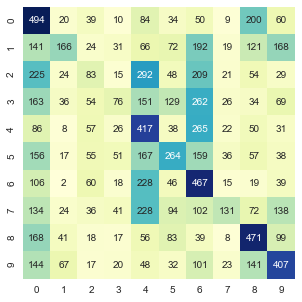

In [25]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

## 3.3 Naive Bayes on fashion MNIST

In [46]:
model2 = NaiveBayes()
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
y_train = fashion_mnist_train["label"].as_matrix()
model2.fit(X_train, y_train)

In [48]:
start = time.time()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255
y_pred, posteriors = model2.predict(X_test, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(fashion_mnist_test["label"], y_pred, posteriors)

Prediction completed. Duration: 1.9s
The accuracy is: 60.20%
The log-likelihood is: 2.15


<div class="alert alert-warning">
We get <b>positive likelihoods</b> because of scaling factor. Having (sometimes) small standard deviations at the denominator of the log argument, we obtain positive values. Of course this fact doesn't change the general meaning of our discussion, which analyze these values relatively to the others.
</div>

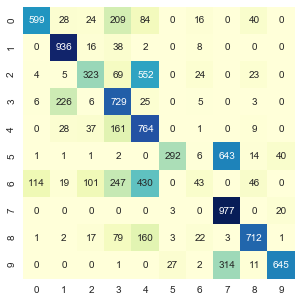

In [33]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(fashion_mnist_test["label"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

## 3.4 Discussion of performances

### 3.4.1 Comparison with random classifier

In [37]:
random_y_pred_cifar = np.random.randint(low=0, high=10, size=len(cifar10_test))
random_y_pred_mnist = np.random.randint(low=0, high=10, size=len(fashion_mnist_test))
print("The accuracy of random model for Fashion MNIST is: %.2f%%" % ((fashion_mnist_test["label"] == random_y_pred_mnist).sum() / len(fashion_mnist_test) * 100))
print("The accuracy of random model for CIFAR-10 is: %.2f%%" % ((cifar10_test["class"] == random_y_pred_mnist).sum() / len(cifar10_test) * 100))

The accuracy of random model for Fashion MNIST is: 10.06%
The accuracy of random model for CIFAR-10 is: 9.67%


<div class="alert alert-success">
<b>Random classifier comparison</b><br>
Of course the accuracy of random classifier is really poor. The accuracy is about 10%, the same result we would obtain if we predict always the same class. We obtained better result but not so much, especially in the case of CIFAR-10 dataset where the accuracy is only about 30%.
</div>

### 3.4.2 Suggestions to improve

<div class="alert alert-success">
In general we didn't obtain good results. We can't do much with the pre-processing because we are wrong a priori: the independence between features is not true (and if you think about, it is reasonable to think that pixels are correlated). Essentialy we should use a model that doesn't make this assumption. As we said before we could use LDA, but in this case we make another assumption: the classes are linearly separable. I tried the scikit implementation and actually improved the accuracy but I did't report anything because I haven't implemented it, for this reason it is not really interesting in this domain. Out there we can find many off-the-shelf models that outperforms the Naïve Bayes. 
<br><br>Now we'll implement Bayesian linear regression to test a completely different approach.
</div>

# 4 Bayesian linear regression

## 4.1 Implementation

In [38]:
from numpy.random import normal

class BayesianLinReg:
    def __init__(self):
        pass
    
    def fit(self, X, y, S):
        '''
        X: feature matrix - 2D
        y: target array
        S: covariance matrix of the prior
        '''
        
        # add the column of '1's in the matrix
        X1 = self.get_X1(X)
        
        # compute w_hat solving the linear system instead of computing the inverse - computational saving
        w_hat = np.linalg.solve(X1.T.dot(X1), X1.T.dot(np.array(y)))
        
        # computing the sigma2 from our data
        self.sigma2_hat = (y - X1.dot(w_hat)).T.dot(y - X1.dot(w_hat)) / len(X1)
        
        # posterior covariance
        self.posterior_cov = np.linalg.inv(X1.T.dot(X1) / self.sigma2_hat + np.linalg.inv(S))
        # posterior mean 
        self.posterior_mean = self.posterior_cov.dot(X1.T).dot(y) / self.sigma2_hat
        
        
    def get_X1(self, X):
        X1 = np.ones((len(X), len(X[0])+1))
        X1[:,:-1] = X
        return X1
    
    def predict(self, X):
        X1 = self.get_X1(X)
        predictions = np.zeros(len(X))
        
        #for each x_new compute the (normal) expecation and sample from it
        for i in range(len(X1)):
            x_new = X1[i,:]
            # the expectation is the integral of the product between the posterior and p(t_new | x_new, w_hat, sigma2)
            # both are normal so the integral is a normal distribution with the following mean and variance
            # for further reading "A first course in Machine Learning" at page 130
            predictions[i] = normal(x_new.T.dot(self.posterior_mean), 
                                    self.sigma2_hat + x_new.T.dot(self.posterior_cov).dot(x_new))
        return predictions
    
    def get_cov_w_hat(self, X):
        X1 = self.get_X1(X)
        return self.sigma2_hat * np.linalg.inv(X1.T.dot(X1))

## 4.2 Fashion MNIST

In [39]:
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
y_train = fashion_mnist_train["label"].as_matrix()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255
blr = BayesianLinReg()
S = np.diag( [100]*(len(X_train[0])+1) )
y_train_matrix = keras.utils.to_categorical(y_train, 10)
blr.fit(X_train, y_train, S)
predictions = blr.predict(X_test)
print("MSE: %.2f" % mean_squared_error(fashion_mnist_test["label"], predictions))

MSE: 5.63


<div class="alert alert-success">
The obtained result is very bad. I tried to change something in the prior and play with the posterior and/or with the normal distribution of the expectation: at the end I figured out the quantity <i>sigma2_hat</i> that we sum to compute the variance of the normal expectation is very high; in few words we try to take care about the high uncertainty present in our data (from the linear regression point of view, of course) but this choice leads to worse results. Deleting this term we have the "best" MSE (<b>1.96</b>), but in this case we take almost always the mean of the normal distribution, in other words we are doing likelihood-based linear regression. 
</div>

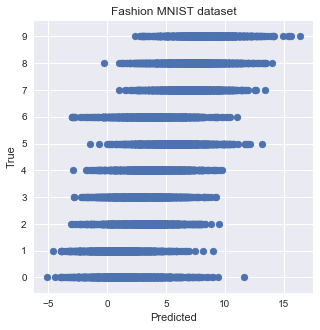

In [40]:
plt.figure(figsize=(5,5))
plt.yticks(list(range(10)))
plt.scatter(predictions, fashion_mnist_test["label"])
plt.title("Fashion MNIST dataset")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [41]:
cov_w_hat = blr.get_cov_w_hat(X_train)
print("Percentage of points below 0.0001: %.5f%%" % (cov_w_hat[cov_w_hat < 10**-4].size / cov_w_hat.size))

Percentage of points below 0.0001: 0.91156%


<div class="alert alert-success">
The plot shows what we've just discussed: for each true class, the prediction values are spread out in a huge range that in the most case covers the whole interval between 0 and 9 but not only, crossing these values and reaching -5 or 15. I've also computed the <b><i>cov{w_hat}</i></b> trying to looking for confirms: the majority of the values inside, which tell us how well defined the parameters are by the data, are really low!
</div>

<div class="alert alert-success">
In order to discretize the prediction values I've simply rounded to the nearest integer. All the negative values (-1, -2, ...) and greater than 9 are then transformed respectively to '0' and '9' class. At this point we can evaluate the accuracy and the confusion matrix.
</div>

In [42]:
predictions = np.rint(predictions).astype(int)
predictions[predictions < 0] = 0
predictions[predictions > 9] = 9
print("Accuracy for MNIST: %.2f%%" % ((fashion_mnist_test["label"] == predictions).sum() / len(fashion_mnist_test) * 100))

Accuracy for MNIST: 21.97%


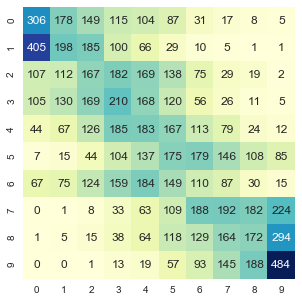

In [43]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(fashion_mnist_test["label"], predictions)
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
From the showed results we can conclude that linear regression is a bad model for this problem. We didn't get good results at all. The accuracy is much lower with respect to Naïve Bayes. It can only predict (quite) correctly class 1 but for all the others the model is getting confused (especially, but not only!) between classes tc, tc-1 and tc+1, where 'tc' stands for true class.<br><br>

The model is wrong for several reasons: first of all we are assuming that there is a linear relationship between the features and the target. Another problem is the target itself: we are assuming that there is a sort of order in the values but it is not true in reality. Numbers are a convention to encode class names. In addition (and it's a big issue) the predictions are also numerical (floating) values and there is no objective rule to convert them into a categorial value. We chose an easy and reasonable way to do it but it is wrong in most of the cases, just take a look at class 2 and 3 in confusion matrix: we probably obtained a lot of values greater than 2.5 (so mapped to 3) but they actually are class 2 and even the contrary. 
</div>

## 4.2b A new discretization approach

<div class="alert alert-success">
From the previous result we realize that we should rethink our approach about class labels. In order to avoid all the problems that we talked about in the last section we use a completely different approach. We apply the OneHotEncoder on the target variable and we run multiple times the linear regression, one for each class label. At the end, for each test-sample, we have 10 regression values: in theory we should assign the class with the nearest value to 1, but here we are dealing with linear regression so we can have values greater than 1! In few words, we simply do an argmax, choosing the highest value as predicted class. Of course in this case we don't need an additional step to discretize and computing MSE doesn't make any sense. Let's see if this approach improve our results. 
</div>

In [44]:
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
y_train = fashion_mnist_train["label"].as_matrix()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255

blr = BayesianLinReg()

S = np.diag( [100]*(len(X_train[0])+1) ) # prior covariance
y_train_matrix = keras.utils.to_categorical(y_train, 10)
predictions = np.zeros((len(X_test), 10))
for i in range(10):
    # fit for each class-column
    blr.fit(X_train, y_train_matrix[:,i], S)
    predictions[:,i] = blr.predict(X_test)
    
# take the class with the highest value
predictions = np.argmax(predictions, axis=1)
print("Accuracy for MNIST: %.2f%%" % ((fashion_mnist_test["label"] == predictions).sum() / len(fashion_mnist_test) * 100))

Accuracy for MNIST: 81.79%


<div class="alert alert-success">
<b>Huge improvement!</b> The new approach seems to work: we improved the accuracy about 20% and bayesian approach works better in this case. We have helped the Bayesian Linear Regression: in this case it doesn't handle all the classes together but we create a specific model for each class, solving all the problems that could occur as explained before.
</div>

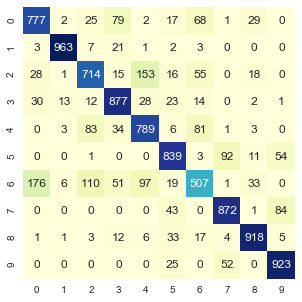

In [45]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(fashion_mnist_test["label"], predictions)
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

## 4.3 CIFAR-10

In [46]:
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255

blr2 = BayesianLinReg()

S = np.diag( [50]*(len(X_train[0])+1) ) # prior covariance
blr2.fit(X_train, y_train, S)
predictions = blr2.predict(X_test)
print("MSE: %.2f" % mean_squared_error(fashion_mnist_test["label"], predictions))

MSE: 65.69


<div class="alert alert-success">
<b>Horrible result</b><br>
Essentialy we have the same problem as before but hugely amplified due to the more complex (in terms of dimensionality) data we have.
</div>

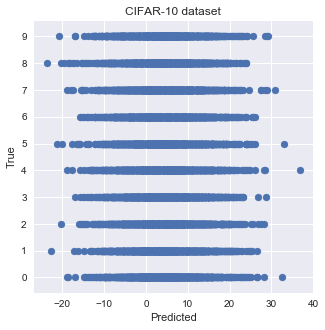

In [47]:
plt.figure(figsize=(5,5))
plt.yticks(list(range(10)))
plt.scatter(predictions, fashion_mnist_test["label"])
plt.title("CIFAR-10 dataset")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

<div class="alert alert-success">
Even in this case we have a huge variance. From the plot we see that we obtain huge values as predictions, passing -30 and 30.
</div>

In [48]:
predictions = np.rint(predictions).astype(int)
predictions[predictions < 0] = 0
predictions[predictions > 9] = 9
print("Accuracy for CIFAR-10: %.2f%%" % ((cifar10_test["class"] == predictions).sum() / len(cifar10_test) * 100))

Accuracy for CIFAR-10: 10.29%


<div class="alert alert-success">
This model with these data is totally useless. We got the same result of a random classifier. I tried also to drop the huge <i>sigma2_hat</i> term (as explained before) to switch to a likelihood-based linear regression but, although we get a far better MSE, the result on the accuracy it is the same. In that case the majority of the prediction values are between 4 and 5. Even in this case we are biased towards two (but different) classes, let's see the confusion matrix.
</div>

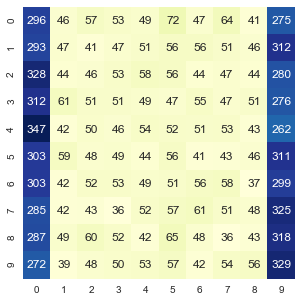

In [49]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], predictions)
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
The simplest discretization approach that we used so far had a lot of problems here: most of the values saturate to 0 or 9, in this way we can say that we actually predict always these 2 classes. Now we are going to use the new discretization approach as before.
</div>

## 4.3b A new discretization approach

In [50]:
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255

blr = BayesianLinReg()

S = np.diag( [100]*(len(X_train[0])+1) ) # prior covariance
y_train_matrix = keras.utils.to_categorical(y_train, 10)
predictions = np.zeros((len(X_test), 10))
for i in range(10):
    # fit for each class-column
    blr.fit(X_train, y_train_matrix[:,i], S)
    predictions[:,i] = blr.predict(X_test)
    
# take the class with the highest value
predictions = np.argmax(predictions, axis=1)
print("Accuracy for CIFAR-10: %.2f%%" % ((cifar10_test["class"] == predictions).sum() / len(cifar10_test) * 100))

Accuracy for CIFAR-10: 31.36%


<div class="alert alert-success">
Using the new approach we improved the result, obtaining a better result than the Naïve Bayes one. Of course it is still objectively low.
</div>

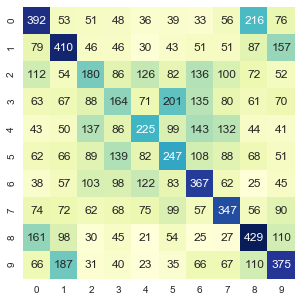

In [51]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], predictions)
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
Even though it contains a lot of false predictions, the confusion matrix is now quite normal. We don't have the "saturation problem" as before, because with the new approach we take care of classes one by one.
</div>

# 5 Bonus questions 

## 5.1 CNN for Fashion MNIST  

In [52]:
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
y_train = fashion_mnist_train["label"].as_matrix()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255
y_test = fashion_mnist_test["label"].as_matrix()

# choose the correct shape of the input (flatten is not good!) based on our running libraries
if K.image_data_format() == 'channels_first':
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_cnn = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# convert class vectors to binary class matrices
y_train_cnn = keras.utils.to_categorical(y_train, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test, num_classes)

'''
LENET ARCHITECTURE
input -> Convolution -> MaxPooling ->Convolution -> MaxPooling -> Flatten -> fully-connected NN
with optional dropout(s) as overfitting prevention
'''
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu', name="output_lenet"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train_cnn, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.1)
score = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2152727519094944
Test accuracy: 0.9206


In [53]:
intermediate_layer_model = Model(inputs=model_cnn.input,
                                 outputs=model_cnn.get_layer("output_lenet").output)
X_train_lenet = intermediate_layer_model.predict(X_train_cnn)
X_test_lenet = intermediate_layer_model.predict(X_test_cnn)

In [54]:
model3 = NaiveBayes()
model3.fit(X_train_lenet, y_train)
start = time.time()
y_pred = model3.predict(X_test_lenet, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(fashion_mnist_test["label"], y_pred[:,0], y_pred[:,1])

Prediction completed. Duration: 0.6s
The accuracy is: 91.23%
The log-likelihood is: 272184.63
The average log-likelihood for correct predictions is: 33.26
The average log-likelihood for wrong predictions is: -35.60


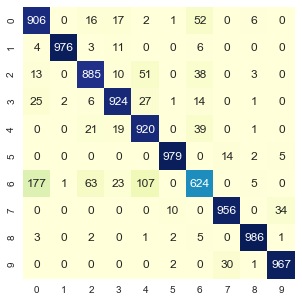

In [55]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(fashion_mnist_test["label"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
We have hugely improved the performances of our algorithm. Thanks to Convolutional Neural Networks we got a new dimensional space (the output of convolutional layers) where we exploit patch informations of the images. I preferred to get the output of the first layer of the fully connected NN, using it as a sort of encoder. The result is almost the same but in this case we are dealing with only 128 features!<br><br>Just notice that the fully-connected Neural Network after the convolutional layers did just a little better: we can conclude that a NN brings a negligible improvement overall, all the "magic" happens in the convolutional layers; then we can use any model and obtaining almost the same (really good) results.
</div>

## 5.2 CNN for CIFAR10

In [56]:
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255
y_test = cifar10_test["class"].as_matrix()

# choose the correct shape of the input (flatten is not good!) based on our running libraries
if K.image_data_format() == 'channels_first':
    X_train_cnn = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test_cnn = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train_cnn = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test_cnn = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# convert class vectors to binary class matrices
y_train_cnn = keras.utils.to_categorical(y_train, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test, num_classes)

'''
LENET ARCHITECTURE
input -> Convolution -> MaxPooling ->Convolution -> MaxPooling -> Flatten -> fully-connected NN
with optional dropout(s) as overfitting prevention
'''
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.3))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu', name="output_lenet"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train_cnn, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.1)
score = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1156709659576416
Test accuracy: 0.606


In [57]:
intermediate_layer_model = Model(inputs=model_cnn.input,
                                 outputs=model_cnn.get_layer("output_lenet").output)
X_train_lenet = intermediate_layer_model.predict(X_train_cnn)
X_test_lenet = intermediate_layer_model.predict(X_test_cnn)

In [58]:
model4 = NaiveBayes()
model4.fit(X_train_lenet, y_train)
start = time.time()
y_pred = model4.predict(X_test_lenet, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(cifar10_test["class"], y_pred[:,0], y_pred[:,1])

Prediction completed. Duration: 0.6s
The accuracy is: 61.08%
The log-likelihood is: -119154.72
The average log-likelihood for correct predictions is: -10.98
The average log-likelihood for wrong predictions is: -13.38


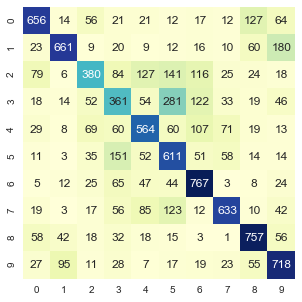

In [59]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
Again, we have hugely improved the performances of our algorithm. But 60% accuracy is still a not so good result. For this reason I decided to go further, applying one of the pre-processing suggestion: converting the images to grayscale.<br><br>Just notice that in this case the Naïve Bayes even did better than the fully-connected NN.
</div>

## 5.3 CNN for CIFAR10-grayscale

In [60]:
m = cifar10_train.as_matrix()
n = cifar10_test.as_matrix()

In [61]:
cifar10gs_train = (0.2126*m[:,:1024] + 0.7152*m[:,1024:2048] + 0.0722*m[:,2048:3072])/255
cifar10gs_test = (0.2126*n[:,:1024] + 0.7152*n[:,1024:2048] + 0.0722*n[:,2048:3072])/255

In [62]:
model = NaiveBayes()
y_train = cifar10_train["class"].as_matrix()
model.fit(cifar10gs_train, y_train)

In [63]:
start = time.time()
y_pred = model.predict(cifar10gs_test, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(cifar10_test["class"], y_pred[:,0], y_pred[:,1])

Prediction completed. Duration: 3.3s
The accuracy is: 26.84%
The log-likelihood is: -5649315.10
The average log-likelihood for correct predictions is: -567.30
The average log-likelihood for wrong predictions is: -564.06


<div class="alert alert-success">
The accuracy is worse than before but it is normal: transforming to grayscale we actually have increased the correlation between features. The goal is to check if grayscale images are better in order to get better patch informations from the CNN. 
</div>

In [64]:
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
X_train = cifar10gs_train
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10gs_test
y_test = cifar10_test["class"].as_matrix()

# choose the correct shape of the input (flatten is not good!) based on our running libraries
if K.image_data_format() == 'channels_first':
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train_cnn = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# convert class vectors to binary class matrices
y_train_cnn = keras.utils.to_categorical(y_train, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test, num_classes)

'''
LENET ARCHITECTURE
input -> Convolution -> MaxPooling ->Convolution -> MaxPooling -> Flatten -> fully-connected NN
with optional dropout(s) as overfitting prevention
'''
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu', name="output_lenet"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train_cnn, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.1)
score = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0152953229904176
Test accuracy: 0.6607


<div class="alert alert-success">
We run the model with the same configuration and we can immediately see that performances, using a fully-connected NN, are better. We expect a similar result for Naïve Bayes. 
</div>

In [65]:
intermediate_layer_model = Model(inputs=model_cnn.input,
                                 outputs=model_cnn.get_layer("output_lenet").output)
X_train_lenet = intermediate_layer_model.predict(X_train_cnn)
X_test_lenet = intermediate_layer_model.predict(X_test_cnn)

In [66]:
model5 = NaiveBayes()
model5.fit(X_train_lenet, y_train)
start = time.time()
y_pred = model5.predict(X_test_lenet, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))
show_performance(cifar10_test["class"], y_pred[:,0], y_pred[:,1])

Prediction completed. Duration: 0.6s
The accuracy is: 65.77%
The log-likelihood is: -762538.50
The average log-likelihood for correct predictions is: -74.32
The average log-likelihood for wrong predictions is: -79.97


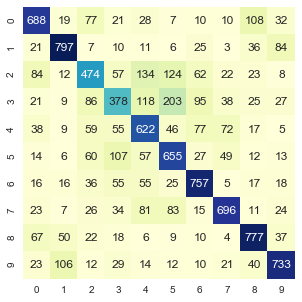

In [67]:
plt.figure(figsize=(5,5))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

<div class="alert alert-success">
As expected we improved again the model: the grayscale images allow us to extract better features with the CNN. Of course the accuracy is not too high (especially with respect to what we obtained with Fashion MNIST) but we can go on in this direction to improve again and again.
</div>